# ODEs Demo: Hopf Bifurcation in the Brusselator Model of Oscillating Chemical Reactions

In [2]:
# import all the packages we need
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

NOTE: This demo is partially based off of problem 20, section 9.8 in the tenth edition of Boyce and DiPrima's book. 

## Some Background + Model Equations

As your personal experience and this video https://youtu.be/ZwyMcV9emmc?t=55 demonstrate, many chemical reactions involve a very rapid relaxation to equilibrium. In particular, a chemical reaction that exhibits any sort of oscillatory behaviour seems counter-intuitive and perhaps impossible. However, such chemical reactions indeed exist! The most famous such process is called the **Belousov-Zhabotinsky (BZ) reaction**, discovered in the mid-twentieth century. You can find a striking video of the BZ reaction here: https://youtu.be/dMF4RjiITGM?t=98 .  

In today's tutorial, we investigate a system of ODEs called the **Brusselator** (for "Brussels" + "oscillator", after the town in which the originators of this model worked). The Brusselator is the simplest chemical reaction model exhibiting oscillations similar to the BZ reaction. For a parameter $b\in (0,\infty)$ roughly representing a reaction rate, the Brusselator takes the form 

\begin{equation}
\left\{
\begin{aligned}
x'(t)&= 1-(b+1)x+\frac14 x^2 y,
\\
y'(t) &= bx-\frac14 x^2 y .
\end{aligned}
\right.
\end{equation}

Here, $x(t)$ and $y(t)$ represent the concentrations of two "intermediate" chemical species present in a reaction. For concreteness, today we can pretend that $x(t)$ is the amount of "red fluid" in the beaker in the BZ video shown above, and $y(t)$ is the amount of "clear fluid" in the beaker. Like the Lotka-Volterra system we saw last week, this is a *nonlinear* system of ODEs. Indeed, any chemical reaction model MUST be nonlinear, otherwise the chemical species involved aren't coupling and there isn't much of a reaction going on! 

I remind you that, as in the Lotka-Volterra tutorial, all parameters and variables are assumed to have been scaled properly and we do not discuss this point further. 


Those of you looking to understand the physical-chemical reasons why the Brusselator gives a suitable toy model of the BZ reaction should see for example Thomas Erneux's *Early models of chemical oscillations failed to provide bounded solutions*, 2018, Phil. Trans. R. Soc.(https://royalsocietypublishing.org/doi/10.1098/rsta.2017.0380). For a more introductory perspective on reaction kinetics, see Melody Dodd's lecture slides and the references therein, available at https://www.math.colostate.edu/~shipman/47/VOLUME-2B-2010.html (though these slides discuss the slightly more complex **Oreganator** model instead of the Brusselator).

Notice that the Brusselator has a unique (prove it!) equilibrium 
$$ \left(x_{\text{eq}}, y_{\text{eq}}\right)^{\mathrm{T}} = \left(1,4b\right)^{\mathrm{T}}.$$

Through both numerical experiments and pen-and-paper linear analysis below, we'll find that the Brusselator exhibits interesting variations in behaviour as the rate parameter $b$ is varied. In particular, we'll discover a special type of bifurcation that's intimately related to the suitability of the Brusselator as a model for oscillatory chemical reactions. 

## Computer Analysis of the Full Model System 

As with Lotka-Volterra, we can start to get our heads around the dynamics of the big bad nonlinear right-hand side with our friend Mr. Computer. We start by prescribing the rate parameter $b$. 

In [16]:
b = 2. #0.1, 1, 2 are pretty nice to try out. 

We now store the equilibrium of the Brusselator. 

In [17]:
x_eq = 1.
y_eq = 4.*b

Next, we make the mesh for the direction field of the nonlinear system. 

In [18]:
xmax = 2. 
ymax = 2.*y_eq
samples_per_axis = 14 # number of sample points per axis

# create mesh grid of data points where we sample direction field/RHS of ODE
x,y = np.meshgrid(np.linspace(0,xmax,samples_per_axis),np.linspace(0,ymax,samples_per_axis))

Define the right-hand side of our system: 

In [19]:
# define direction field sampled at mesh grid of data points
u = 1.-(b+1)*x+0.25*x*x*y
v = b*x-0.25*x*x*y

Now, we plot the Brusselator's direction field for the chosen $b$. Unfortunately, you may have to manually tweak some of the plot parameters here to get a really nice picture depending on the value of $b$ you chose. 

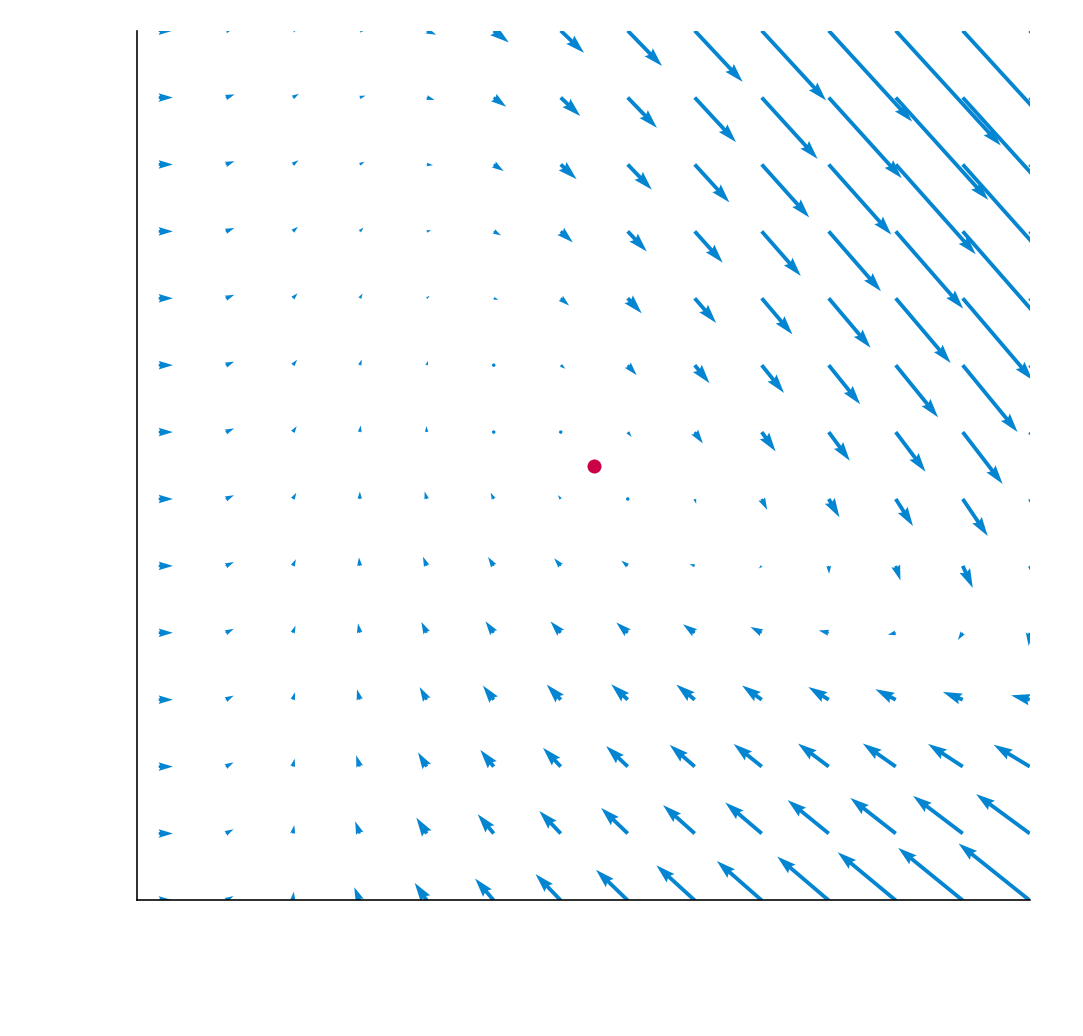

In [20]:
fig, ax = plt.subplots()

# define all plot parameters + ensure axis labels all look nice. 
# Lots of this stuff is purely optional. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlim([-0.05, xmax])
plt.ylim([0, ymax])

plt.xlabel(r"$x$", fontsize=32, color = 'w')
plt.ylabel(r"$y$", fontsize=32, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=24, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=24, rotation=0, color = 'w')

# plot the nonzero equilibrium
plt.plot(x_eq, y_eq,'o', color='xkcd:ruby')

# sketch arrows of ODE's direction field. 
    
plt.quiver(x,y,u,v, color='xkcd:cerulean', linewidth=4)

# adjust figure aspect ratio and size for maximum clarity
#ax.set_aspect(1.)
plt.rcParams['figure.figsize'] = [8, 8]

# finally, show the plot
plt.show()

The red dot in the image above denotes our equilibrium point. Notice the dramatic change in the direction field as $b$ goes from $1$ to $2$! 

Now, we do some numerical experiments to get a feel for how specific solutions to the Brusselator look. As with Lotka-Volterra, don't worry about the details used in the code block below to do the numerical solve. 

In [21]:
T= 70

# Prescribe initial condition.s... default is a very very tiny (<=10%) perturbation of equilibrium
x0 = 1.1*x_eq
y0 = 0.96*y_eq

# Prescribe time step
h= 0.01 

# Determine number of time steps, making sure to store this as a Python integer. 
N = np.int(T/h) 

# Initialize solution vectors z, using this storage convention:
# z= [(x(0),y(0))^T | (x(h),y(h))^T | ... | (x(N*h),y(N*h))^T] 

z = np.zeros((2, N+1), dtype=float)

z[:,0] = np.array([x0, y0])

# Define right-hand side of ODE system. 
def f(z):
    z=np.array(z) 
    
    x,y = z
    
    # need to convert x, y to arrays in order to multiply them by the float b
    x = np.array(x)
    y = np.array(y)
    
    # Initialize f
    f=np.zeros(2, dtype=float)
    
    # Compute f = [ f[0], f[1] ]^T in terms of x and y    
    f[0] = 1. -b*x-x+0.25*x*x*y
    
    f[1] = b*x-0.25*x*x*y
    
    return f

# We also must define the nonlinear map whose roots need to be found at each time-step. This could be avoided by using Python's nifty "lambda" tool, but I want to keep the syntax as transparent as possible. 
def F(z, *params):
    z0 = params
    
    F = 2.*h*f(z) - 3.*z + z0

    return np.reshape(F,(2)) # enforce F to have the correct shape
    
# Since we are using a 3-step method, we need to set solution at time h before we can enter the time-stepping loop proper. We use the backward Euler method to do this.  
def F_euler(z, *params):
    z0 = params
    
    F_euler = h*f(z) - z + z0

    return np.reshape(F_euler,(2)) 
    
# Use backward Euler to find solution at time h
z[:, 1]= fsolve(F_euler, np.zeros((2), dtype=float), args=(z[:,0])) 
    
# Do time stepping 
for n in np.arange(2,N+1):

    # Set parameters for input into F
    params = (4.*z[:,n-1]-z[:,n-2])

    # Solve nonlinear system via Powell's modification of Newton's method through the scipy function "fsolve", which (as we have used it here) takes in a function F, an initial guess at the root of F, and any extra parameters that need to be passed into F. 
    z[:, n] = fsolve(F, np.zeros((2), dtype=float),args=params) 
  

Now, we plot the results of the simulation. 

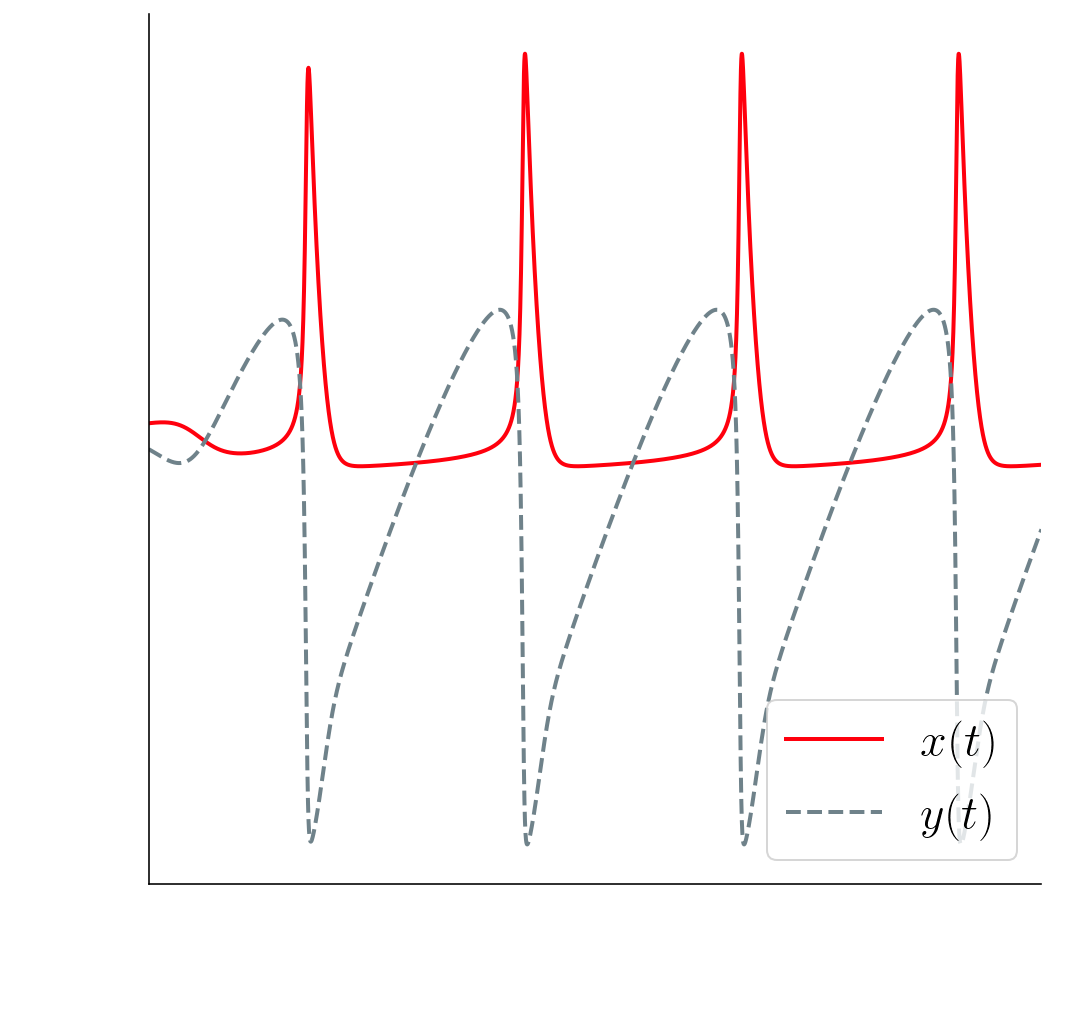

In [22]:
# Plot solution
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

t=np.linspace(0,T,N)

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.plot(t, z[0,1:]-x_eq, linewidth=2 , color='xkcd:bright red')
plt.plot(t, z[1,1:]-y_eq, linewidth=2, color='xkcd:steel grey', linestyle='dashed')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlim([0,T])
#plt.ylim([-0.35, 0.35])

plt.legend(['$x(t)$', '$y(t)$'], loc='lower right', fontsize=24)

plt.xlabel(r"$t$", fontsize=30, color = 'w')
plt.ylabel(r"Deviation from Equilibrium", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=24, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=24, rotation=0, color = 'w')

#"""

plt.rcParams['figure.figsize'] = [8, 8]

plt.show()

For $b=1$, you should find that the system wiggles around for a bit before relaxing to equilibrium. This is not the kind of solution we want! How can we get honest-to-goodness chemical oscillations? By turning up $b$! For $b=2$, we definitely see non-sinusoidal oscillations in $x$ and $y$, as observed in the BZ reaction video. So, the Brusselator can definitely capture some highly nontrivial oscillations. Additionally, the dramatic change in qualitative behaviour of solutions when $b$ surpasses a threshold is indicative of a bifurcation. We'll return to the question of determining a precise bifurcation value $b_{*}$ later (though you can start determining $b_{*}$ yourself by performing more numerical experiments!). 

Something worth mentioning about Brusselator oscillations: these are not like Lotka-Volterra oscllations that always remain close to the equilibrium point. Indeed, they are always a finite (as opposed to infinitesimal) distance away from the equilibrium point. So, for large enough $b$, the Brusselator takes initial data and drags it over to a special nonlinear oscillation very quickly. This means the Brusselator has a *stable limit cycle* for sufficiently large $b$. A stable limit cycle is the canonical example of a nonzero-dimensional attracting manifold for a nonlinear dynamical system. 

## Linearization of the Brusselator & Bifurcation Analysis

Let us express the right-hand side of the Brusselator as 
$$  F(x,y) = \left(1-(b+1)x+\frac12x^2y,  \quad bx-\frac12x^2y\right)^{\mathrm{T}}.$$

By direct computation, we verify that the Jacobian of $F$ at any point $(x,y)^{\mathrm{T}}\in \mathbb{R}^2$ is given by 

$$ 
\mathrm{D}F(x,y) = \begin{pmatrix} -(b+1) +\frac12 xy & \phantom{-}\frac14 x^2 \\ b-\frac12 xy & -\frac14 x^2\end{pmatrix}.
$$

In particular, the Jacobian of $F$ at the equilibrium $(x_{\text{eq}}, y_{\text{eq}})^{\mathrm{T}} = (1, 4b)^{\mathrm{T}} $ is given by 

$$
A\doteq \mathrm{D}F(1,4b) = \begin{pmatrix} b-1 & \phantom{-}\frac14 \\ -b & -\frac14 \end{pmatrix}.
$$

We immediately verify that 
$$
\mathrm{det}A = -\frac14\left(b-1\right)+\frac14 b = \frac14 \neq 0,
$$
so linearization about  $(x_{\text{eq}}, y_{\text{eq}})^{\mathrm{T}}$  actually makes sense. 

To determine the linear stability characteristics of $(x_{\text{eq}}, y_{\text{eq}})^{\mathrm{T}} = (1, 4b)^{\mathrm{T}} $ as a function of $b$, we must first find the roots of the degree two algebraic equation 
$$ 
0 = \mathrm{det}\left(A-\lambda \mathrm{Id}\right) = \left((b-1)-\lambda\right)\left(-\frac14 -\lambda\right)+\frac{b}{4}.
$$
Expanding this out and multiplying both sides by $4$ to clear denominators gives us
$$ 
0 = 4\lambda^2+(5-4b)\lambda +1. 
$$
The quadratic formula then yields 
$$ 
\lambda = \lambda_{\pm}\doteq \frac18 \left[4b-5 \pm \sqrt{16 b^2-40 b +9}\right]. 
$$

To go further with linear stability analysis, we need to determine when the eigenvalues are purely really and when they are not.  Both eigenvalues have a nonzero imaginary part precisely when 
$$ 16b^2 -40b +9 < 0. $$
Another application of the quadratic formula tells us that the above holds when 
$$ \frac14 < b < \frac94. $$
Conversely, both eigenvalues are purely real when 
$$ b\in \left[0, \frac14\right]\bigcup\left[\frac94,\infty\right). $$

Now, we are finally ready to diagnose the linear stability of our only equilibrium $(x_{\text{eq}}, y_{\text{eq}})^{\mathrm{T}}$. This amounts to finding the sign of the real part of both eigenvalues. This is easy when $b$ has a nonzero imaginary part:

1) if $b\in \left(\frac14, \frac54\right)$, then the sign of the real part of both eigenvalues is negative and $(0,0)^{\mathrm{T}}$ is an inward spiral equilibrium, in particular we have *linear asymptotic stability*; 

2) if $b\in \left(\frac54, \frac94\right)$, then the sign of the real part of both eigenvalues is positive and $(0,0)^{\mathrm{T}}$ is an outward spiral equilibrium, in particular we have *linear instability*. 

When $b$ is purely real, we need to do a little more work. First, we plot the eigenvalues as a function of $b$ for $b\in \left(0,\frac14\right). $

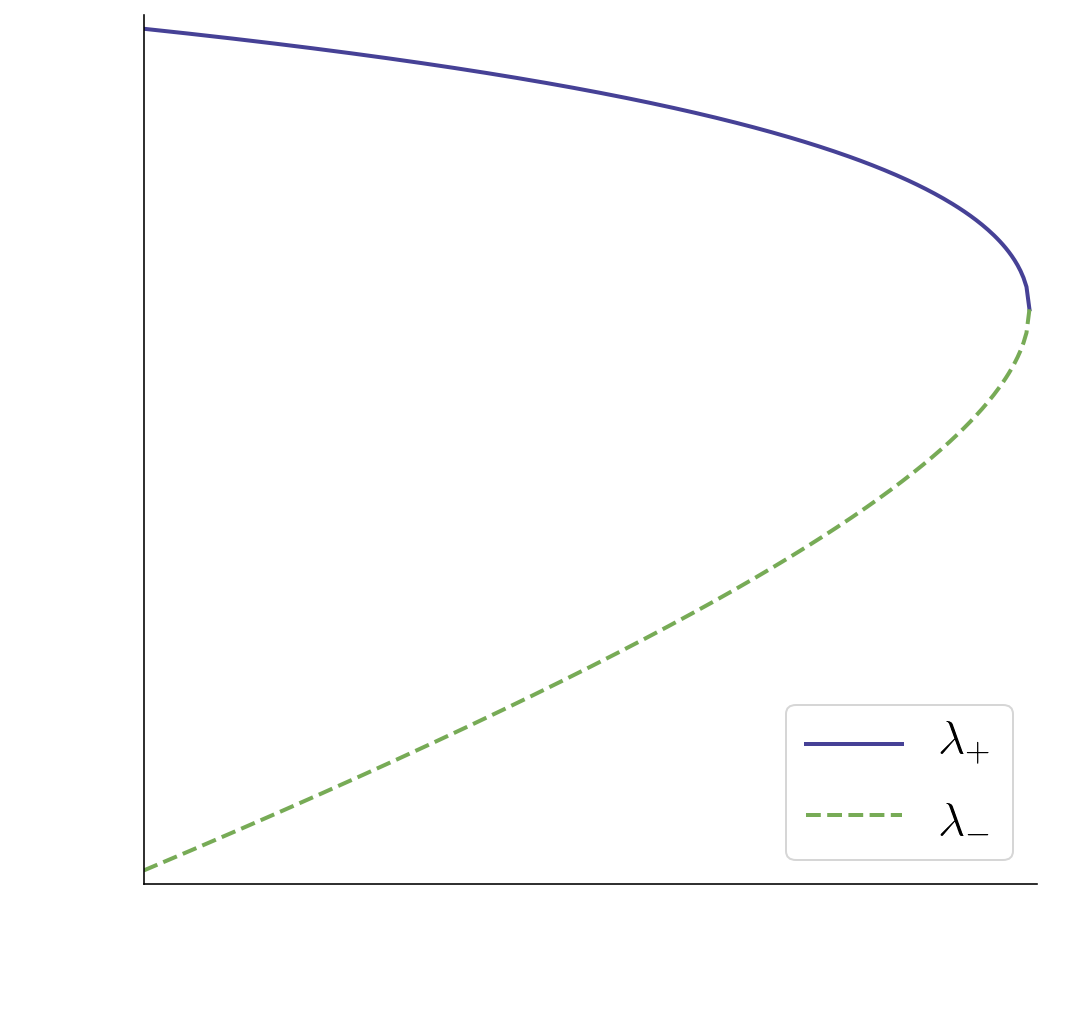

In [10]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

xdata = np.linspace(0,0.25,300)
ydata_plus = 4.*xdata-5.+np.sqrt(16.*xdata**2-40.*xdata+9.)
ydata_minus = 4.*xdata-5.-np.sqrt(16.*xdata**2-40.*xdata+9.)

plt.plot(xdata, ydata_plus, linewidth=2 , color='xkcd:blueberry')
plt.plot(xdata, ydata_minus, linewidth=2 , color='xkcd:asparagus', linestyle='dashed')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlim([0,0.252])
plt.ylim([-8.1, -1.9])

plt.legend(['$\lambda_{+}$', '$\lambda_{-}$'], loc='best', fontsize=24)

plt.xlabel(r"$b$", fontsize=30, color = 'w')
plt.ylabel(r"Eigenvalues", fontsize=30, color = 'w', rotation=90)

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=22, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=22, rotation=0, color = 'w')

#"""
plt.show()

From this figure, we find that both eigenvalues are purely real and negative when $b\in \left(0,\frac14\right)$. Therefore, in this case, we have that $(0,0)^{\mathrm{T}}$ is a nodal sink for the linear system. In particular, the equilibrium is *linearly asymptotically stable* for such $b$. 

Now, we do the same for First, we plot the eigenvalues as a function of $b$ for $b\in \left(\frac94,\infty\right). $

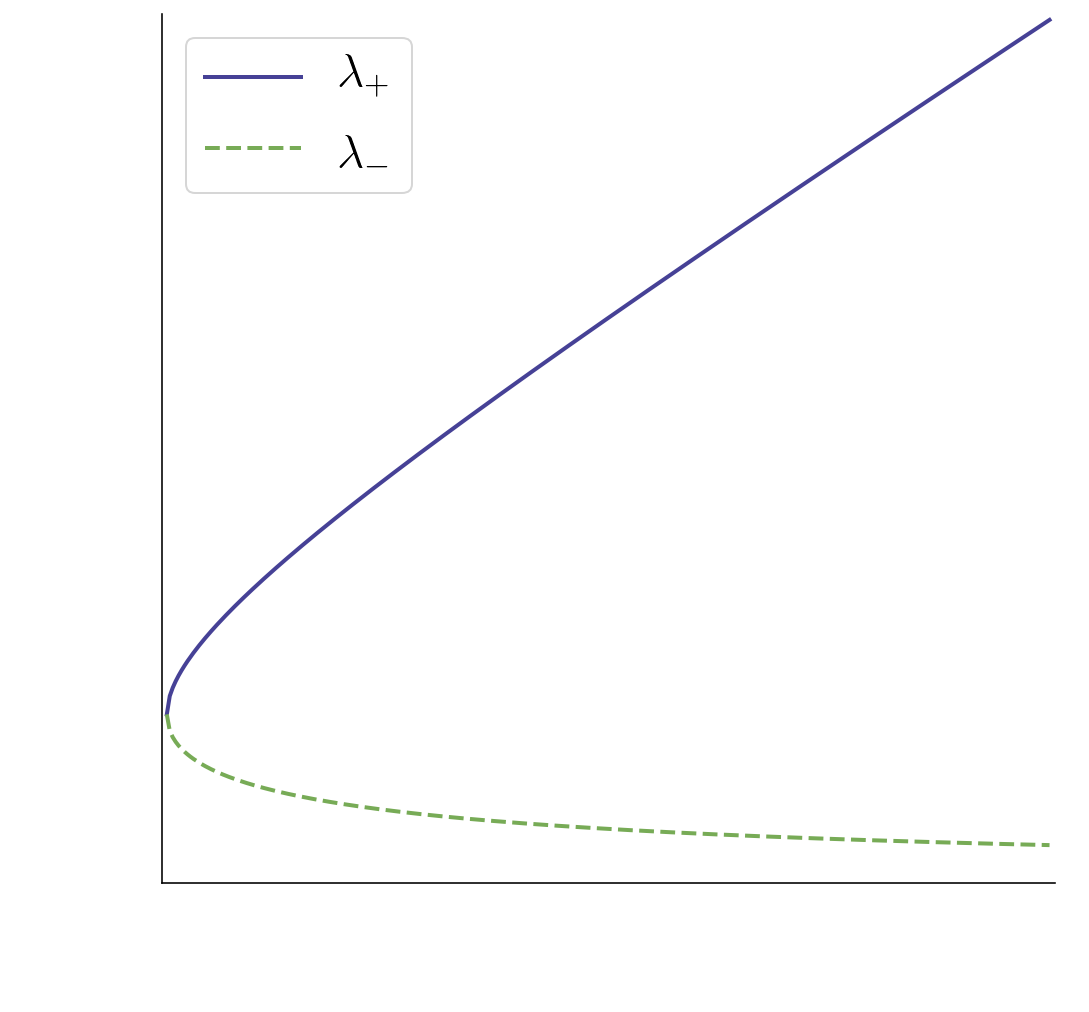

In [11]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

xdata = np.linspace(2.25,4,300)
ydata_plus = 4.*xdata-5.+np.sqrt(16.*xdata**2-40.*xdata+9.)
ydata_minus = 4.*xdata-5.-np.sqrt(16.*xdata**2-40.*xdata+9.)

plt.plot(xdata, ydata_plus, linewidth=2 , color='xkcd:blueberry')
plt.plot(xdata, ydata_minus, linewidth=2 , color='xkcd:asparagus', linestyle='dashed')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlim([2.24,4.01])
plt.ylim([-0.2, 21.4])

plt.legend(['$\lambda_{+}$', '$\lambda_{-}$'], loc='best', fontsize=24)

plt.xlabel(r"$b$", fontsize=30, color = 'w')
plt.ylabel(r"Eigenvalues", fontsize=30, color = 'w', rotation=90)

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=22, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=22, rotation=0, color = 'w')

#"""
plt.show()

So, when $b\in \left(\frac94,\infty\right)$, we find that both eigenvalues are both strictly positive. We conclude that $(0,0)^{\mathrm{T}}$ is a nodal source for the linearized system, hence our equilibrium is *linearly unstable* for such $b$. Note that, even though the picture above only shows $\frac94\leq b\leq 4$, a simple calculus exercise shows that, for large $b$, 
$$ \lambda_{+} \approx b, \quad \lambda_{-}\approx 0.$$
So, the above picture is representative of all $b> \frac94$. 

For completeness, we also plot the direction field for the linearized system. First, we define the right-hand side of the linearized system. 

In [12]:
xmax_0 = 6 
ymax_0 = 6
samples_per_axis = 14 # number of sample points per axis

# create mesh grid of data points where we sample direction field/RHS of ODE
x_0,y_0 = np.meshgrid(np.linspace(-xmax_0,xmax_0,samples_per_axis),np.linspace(-xmax_0,ymax_0,samples_per_axis))

In [13]:
# define direction field sampled at mesh grid of data points
u_lin0 = (b-1)*x_0 + 0.25*y_0
v_lin0 = -b*x_0 -0.25*y_0

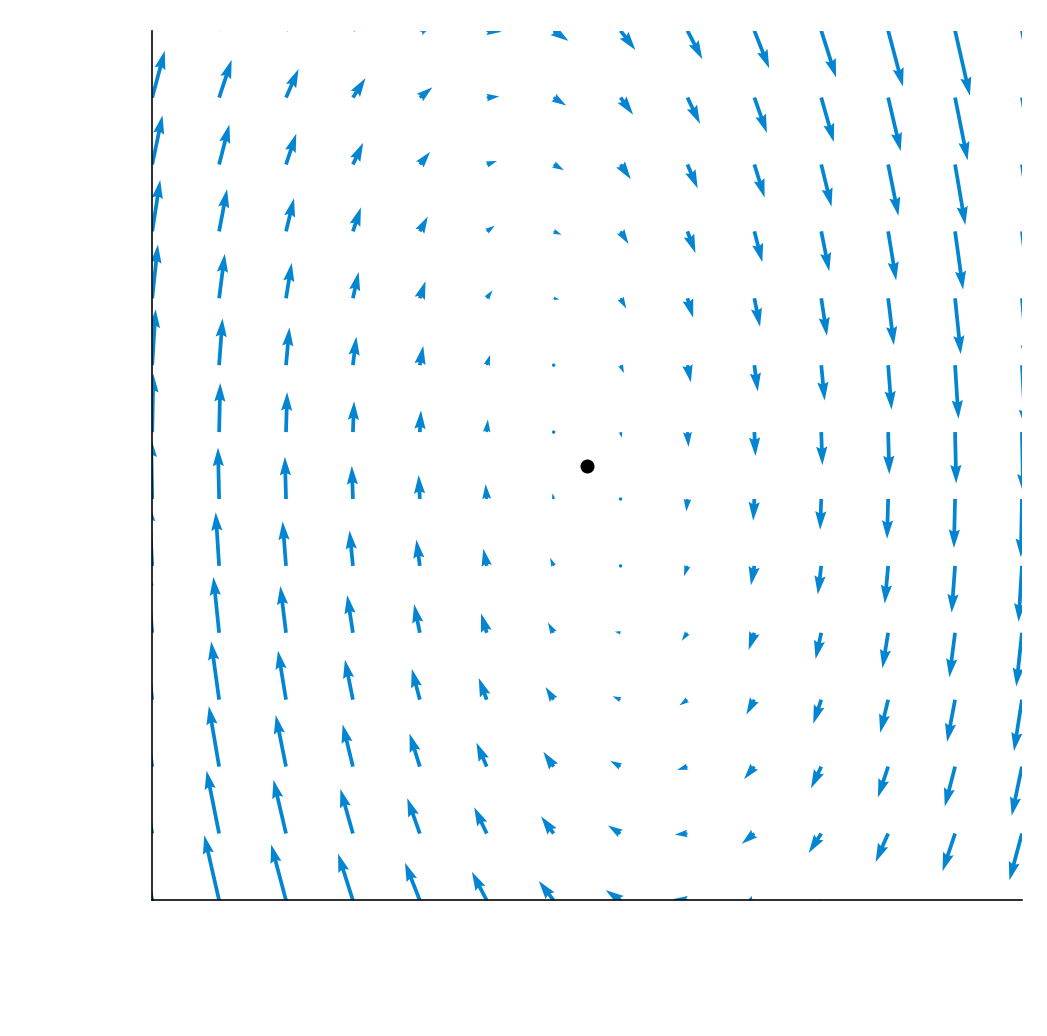

In [14]:
fig, ax = plt.subplots()

# define all plot parameters + ensure axis labels all look nice. 
# Lots of this stuff is purely optional. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlim([-xmax_0, xmax_0])
plt.ylim([-ymax_0,ymax_0])

plt.xlabel(r"$x-x_{\mathrm{eq}}$", fontsize=32, color = 'w') #todo: change these labels!
plt.ylabel(r"$y-y_{\mathrm{eq}}$", fontsize=32, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=24, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=24, rotation=0, color = 'w')

# plot the zero equilibrium
plt.plot(0., 0.,'ko')

plt.quiver(x_0,y_0,u_lin0,v_lin0, color='xkcd:cerulean', linewidth=3)

# adjust figure aspect ratio and size for maximum clarity

ax.set_aspect(1)
plt.rcParams['figure.figsize'] = [8, 8]

# finally, show the plot
plt.show()

In summary, this linear analysis tells us that 
$\left(X_{\text{eq}}, y_{\text{eq}}\right)^{\mathrm{T}}$ is linearly asymptotically stable for $b\in \left(0,\frac54\right)$ and linearly unstable for $b\in \left(\frac54, \infty\right)$. Thus, there is a sharp change in the linear stability characteristics as $b$ passes through the *bifurcation value*
$$ b_{*} = \frac54.  $$
The particular type of bifurcation exhibited by the Brusselator (an isolated, linearly asymptotically stable equilibrium transitions into a linearly unstable equilibrium) is called a *Hopf bifurcation*. 

Our earlier numerical experiments hinted at the presence of a bifurcation: below a threshold $b$, we would quickly relax to equilibrium after one or two oscillations, while above the threshold $b$ we would experience non-sinusoidal oscillations far from equilibrium. As mentioned earlier, this is the defining characteristic of a stable limit cycle. Notice that the concept of "activation threshold" is captured perfectly by our linear bifurcation analysis. However, the linear bifurcation analysis presented here tells us nothing about the existence of limit cycles. In particular, a too-naive application of the linear analysis would indicate that the Brusselator sends initial data off to infinity exponentially quickly when $b>\frac54$, which we know to be false through numerical experiments: for such $b$, all we can really say through linear analysis is that we eventually get a finite distance away from equilibrium, even if we start very close to equilibrium. So, exercise caution when using linearization: it can't predict "truly nonlinear" features like limit cycles. 

## A Teaser for PDEs

You may ask a natural question: what happens if we didn't thoroughly mix all the BZ reactants to make a homogeneous solution? In other words, what does our beaker look like if different regions contain vastly different concentrations of reactants? The following video gives some empirical insight: https://youtu.be/PpyKSRo8Iec?t=5 

Wow! How can we mathematically model such wonderful and complex patterns? Of course, since the reactant concentration now varies in space as well as time, we must be in the business of modelling with *partial* differential equations. Under the assumption that each reactant diffuses through the solution according to Fick's law, one can combine the Brusselator ODEs with a PDE called the **diffusion equation** to model the dynamics displayed in the video via a special **reaction-diffusion equation**. The study of complex pattern formation in solutions to reaction-diffusion equations is a rich area of both pure and computational mathematics, to say nothing of its applications in natural science (for instance, in the study of dentition in young crocodiles cf. volume 2 of Murray's *Mathematical Biology*). 

In an undergraduate course like APM 346, you will at least learn about the diffusion equation. So, if this tutorial has piqued your interest, a good way to learn more is to take APM 346 :)  